## Business Understanding

We aim to apply clustering to our crime dataset.  Specifically, we will use crime attributes like crime type, day of the week, daytime and season to determine patterns of crimes that occur by location (GeoCell).  By doing this, we can generally describe the nature of the crimes that occur in a specific area.  

### Measuring Effectiveness

We will use the Silhouette Coefficient (score) to determine cluster effectiveness.  The Silhouette score uses euclidean distance to determine if clusters are dense and well separated.  The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering.  Scores closer to 1 are better.


## Data Understanding

The following features are used in this clustering analysis:

|Feature | Description |
|:-------|:------------|
|Daytime | This specifies the general time of day a crime occurred.  i.e. Early Morning, Morning, Day, Evening, Late Evening, Night |
|Day_Name | The weekday name in which a crime occurred |
|Month | The month in which a crime occurred |
|Season | The season in which a crime occurred.  i.e. Winter, Spring, Summer, Fall |
|OFNS_DESC | Description of the crime that occurred. |
|GeoCell | This breaks the NYC area into 100 equally sized squares using the x and y coordinates of a crime |

We will one hot encode the categorical variables (not including GeoCell), group by GeoCell, then aggregate (sum) the one hot encoded features to get continuous variables.  This will then be used to apply PCA for further cluster analysis.

With the fields above, we will be able to identify how the records in our dataset cluster and determine the mode of the string features and the average of the continuous features to arrive at a general description.

### Pull in the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In C:\Users\BGaither\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\BGaither\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\BGaither\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\BGaither\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\BGaither\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_c

In [3]:
#load csv
file_path = "C:\\Users\\BGaither\\OneDrive - McAfee\\Other\\school\\SMU\\Courses\\Fall 2020\\Machine Learning I\\Lab1\\Data_NYPD\\Modified_Data_Sets\\FE2_NYPD_Complaint_Data_Historic.csv"
#load Data into Pandas
df_Crime = pd.read_csv(file_path)

C:\Users\BGaither\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_Crime.head(5)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,Month,Day,Year,Duration_lbl,Season,Daytime,GeoCell,GeoCell_X,GeoCell_Y,OFNS_DESC_TYPE
0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,December,31.0,2015.0,NaN,Winter,Late Night,77.0,7.0,8.0,Non-Violent Crime
1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON NEGL. MANSLAUGHTER,NaN,NaN,...,December,31.0,2015.0,NaN,Winter,Late Night,49.0,9.0,5.0,Violent Crime
2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",...,December,31.0,2015.0,NaN,Winter,Late Night,76.0,6.0,8.0,Non-Violent Crime
3,968417082,12/31/2015,23:30:00,NaN,NaN,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,December,31.0,2015.0,NaN,Winter,Late Night,40.0,10.0,4.0,Violent Crime
4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,December,31.0,2015.0,Short,Winter,Late Night,55.0,5.0,6.0,Violent Crime


In [5]:
df_Crime.dtypes

CMPLNT_NUM             int64
CMPLNT_FR_DT          object
CMPLNT_FR_TM          object
CMPLNT_TO_DT          object
CMPLNT_TO_TM          object
RPT_DT                object
KY_CD                  int64
OFNS_DESC             object
PD_CD                float64
PD_DESC               object
CRM_ATPT_CPTD_CD      object
LAW_CAT_CD            object
JURIS_DESC            object
BORO_NM               object
ADDR_PCT_CD          float64
LOC_OF_OCCUR_DESC     object
PREM_TYP_DESC         object
PARKS_NM              object
HADEVELOPT            object
X_COORD_CD           float64
Y_COORD_CD           float64
Latitude             float64
Longitude            float64
Lat_Lon               object
Start_Dt_Tm           object
End_Dt_Tm             object
Day_Name              object
Duration             float64
Duration_to_PD       float64
Month                 object
Day                  float64
Year                 float64
Duration_lbl          object
Season                object
Daytime       

Remove rows with missing data

In [11]:
df_Crime = df_Crime.dropna()

Next, we'll one hot encode the categorical variables

In [12]:
#one hot encode the categorical features
from sklearn.preprocessing import StandardScaler, OneHotEncoder

columns_to_encode = ['OFNS_DESC','Day_Name','Month','Season','Daytime']
columns_no_change = ['GeoCell']

df_existing = df_Crime[columns_no_change]
existing_cols = df_existing.to_numpy()

#encoder 
ohe = OneHotEncoder(sparse=False)

#ohe separate columns
encoded_columns = ohe.fit_transform(df_Crime[columns_to_encode])

#concatenate processed columns back together for X
df_Crime = np.concatenate([encoded_columns,existing_cols],axis=1)

#get the column names back to the dataframe
df1 = pd.DataFrame(df_Crime)
feature_names = ohe.get_feature_names().tolist()
col_names = feature_names+columns_no_change
df1.columns = col_names
df_Crime = df1

In [13]:
df_Crime.head(5)

,x0_ASSAULT 3 & RELATED OFFENSES,x0_CRIMINAL TRESPASS,x0_DANGEROUS DRUGS,x0_DANGEROUS WEAPONS,x0_FELONY ASSAULT,x0_FRAUDS,x0_GRAND LARCENY,x0_HARRASSMENT 2,x0_MISCELLANEOUS PENAL LAW,x0_OFFENSES AGAINST PUBLIC ADMINI,...,x3_Spring,x3_Summer,x3_Winter,x4_Day,x4_Early Morning,x4_Evening,x4_Late Night,x4_Morning,x4_Night,GeoCell
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,45.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,45.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,87.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,76.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,37.0


In [19]:
df_Crime.columns.tolist()

['x0_ASSAULT 3 & RELATED OFFENSES',
 'x0_CRIMINAL TRESPASS',
 'x0_DANGEROUS DRUGS',
 'x0_DANGEROUS WEAPONS',
 'x0_FELONY ASSAULT',
 'x0_FRAUDS',
 'x0_GRAND LARCENY',
 'x0_HARRASSMENT 2',
 'x0_MISCELLANEOUS PENAL LAW',
 'x0_OFFENSES AGAINST PUBLIC ADMINI',
 'x0_PETIT LARCENY',
 'x0_POSSESSION OF STOLEN PROPERTY',
 'x0_ROBBERY',
 'x1_Friday',
 'x1_Monday',
 'x1_Saturday',
 'x1_Sunday',
 'x1_Thursday',
 'x1_Tuesday',
 'x1_Wednesday',
 'x2_August',
 'x2_December',
 'x2_February',
 'x2_July',
 'x2_June',
 'x2_March',
 'x2_May',
 'x2_November',
 'x2_October',
 'x2_September',
 'x3_Fall',
 'x3_Spring',
 'x3_Summer',
 'x3_Winter',
 'x4_Day',
 'x4_Early Morning',
 'x4_Evening',
 'x4_Late Night',
 'x4_Morning',
 'x4_Night',
 'GeoCell']

Now we will group by GeoCell and aggregate all of the one hot encoded variables so that we end up with continuous variables that give the sum of times given variables were true by GeoCell.

In [33]:
df_new = df_Crime.groupby(['GeoCell'])['x0_ASSAULT 3 & RELATED OFFENSES',
                                         'x0_CRIMINAL TRESPASS',
                                         'x0_DANGEROUS DRUGS',
                                         'x0_DANGEROUS WEAPONS',
                                         'x0_FELONY ASSAULT',
                                         'x0_FRAUDS',
                                         'x0_GRAND LARCENY',
                                         'x0_HARRASSMENT 2',
                                         'x0_MISCELLANEOUS PENAL LAW',
                                         'x0_OFFENSES AGAINST PUBLIC ADMINI',
                                         'x0_PETIT LARCENY',
                                         'x0_POSSESSION OF STOLEN PROPERTY',
                                         'x0_ROBBERY',
                                         'x1_Friday',
                                         'x1_Monday',
                                         'x1_Saturday',
                                         'x1_Sunday',
                                         'x1_Thursday',
                                         'x1_Tuesday',
                                         'x1_Wednesday',
                                         'x2_August',
                                         'x2_December',
                                         'x2_February',
                                         'x2_July',
                                         'x2_June',
                                         'x2_March',
                                         'x2_May',
                                         'x2_November',
                                         'x2_October',
                                         'x2_September',
                                         'x3_Fall',
                                         'x3_Spring',
                                         'x3_Summer',
                                         'x3_Winter',
                                         'x4_Day',
                                         'x4_Early Morning',
                                         'x4_Evening',
                                         'x4_Late Night',
                                         'x4_Morning',
                                         'x4_Night'].apply(lambda x : x.astype(int).sum())
df_new.reset_index(inplace=True)
df_new.head(5)

C:\Users\BGaither\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,GeoCell,x0_ASSAULT 3 & RELATED OFFENSES,x0_CRIMINAL TRESPASS,x0_DANGEROUS DRUGS,x0_DANGEROUS WEAPONS,x0_FELONY ASSAULT,x0_FRAUDS,x0_GRAND LARCENY,x0_HARRASSMENT 2,x0_MISCELLANEOUS PENAL LAW,...,x3_Fall,x3_Spring,x3_Summer,x3_Winter,x4_Day,x4_Early Morning,x4_Evening,x4_Late Night,x4_Morning,x4_Night
0,23.0,2,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,1,1,0,0
1,25.0,0,0,1,0,0,1,0,0,0,...,0,0,2,0,0,0,0,2,0,0
2,26.0,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,1
3,32.0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
4,37.0,1,0,10,1,0,0,1,0,0,...,6,1,5,1,1,0,2,2,1,7


Next, we will scale the aggregated values prior to performing PCA

In [34]:
#scale specific columns
from sklearn.preprocessing import StandardScaler, OneHotEncoder

columns_to_scale = ['x0_ASSAULT 3 & RELATED OFFENSES',
                                         'x0_CRIMINAL TRESPASS',
                                         'x0_DANGEROUS DRUGS',
                                         'x0_DANGEROUS WEAPONS',
                                         'x0_FELONY ASSAULT',
                                         'x0_FRAUDS',
                                         'x0_GRAND LARCENY',
                                         'x0_HARRASSMENT 2',
                                         'x0_MISCELLANEOUS PENAL LAW',
                                         'x0_OFFENSES AGAINST PUBLIC ADMINI',
                                         'x0_PETIT LARCENY',
                                         'x0_POSSESSION OF STOLEN PROPERTY',
                                         'x0_ROBBERY',
                                         'x1_Friday',
                                         'x1_Monday',
                                         'x1_Saturday',
                                         'x1_Sunday',
                                         'x1_Thursday',
                                         'x1_Tuesday',
                                         'x1_Wednesday',
                                         'x2_August',
                                         'x2_December',
                                         'x2_February',
                                         'x2_July',
                                         'x2_June',
                                         'x2_March',
                                         'x2_May',
                                         'x2_November',
                                         'x2_October',
                                         'x2_September',
                                         'x3_Fall',
                                         'x3_Spring',
                                         'x3_Summer',
                                         'x3_Winter',
                                         'x4_Day',
                                         'x4_Early Morning',
                                         'x4_Evening',
                                         'x4_Late Night',
                                         'x4_Morning',
                                         'x4_Night']

columns_no_change = ['GeoCell']

df_existing = df_new[columns_no_change]
existing_cols = df_existing.to_numpy()

#scaler
scaler = StandardScaler()

#scale and encode separate columns
scaled_columns = scaler.fit_transform(df_new[columns_to_scale])

#concatenate processed columns back together for X_train
X_np = np.concatenate([scaled_columns,existing_cols],axis=1)

#convert the numpy array back to a pandas dataframe for X_train
df1 = pd.DataFrame(X_np)
#get the column names back to the dataframe
col_names = columns_to_scale+columns_no_change
df1.columns = col_names
df_scale = df1

In [35]:
df_scale.head(5)

,x0_ASSAULT 3 & RELATED OFFENSES,x0_CRIMINAL TRESPASS,x0_DANGEROUS DRUGS,x0_DANGEROUS WEAPONS,x0_FELONY ASSAULT,x0_FRAUDS,x0_GRAND LARCENY,x0_HARRASSMENT 2,x0_MISCELLANEOUS PENAL LAW,x0_OFFENSES AGAINST PUBLIC ADMINI,...,x3_Spring,x3_Summer,x3_Winter,x4_Day,x4_Early Morning,x4_Evening,x4_Late Night,x4_Morning,x4_Night,GeoCell
0,2.694439,-0.306186,-0.556230,-0.541736,-0.452679,-0.522233,-0.452679,-0.591608,-0.408248,-0.518875,...,-0.650945,-0.108135,-0.448879,-0.541736,-0.223607,0.429198,-0.151911,-0.632456,-0.820328,23.0
1,-0.734847,-0.306186,-0.139058,-0.541736,-0.452679,1.305582,-0.452679,-0.591608,-0.408248,-0.518875,...,-0.650945,-0.108135,-0.448879,-0.541736,-0.223607,-0.858395,0.911465,-0.632456,-0.820328,25.0
2,-0.734847,-0.306186,-0.139058,-0.541736,-0.452679,-0.522233,-0.452679,-0.591608,-0.408248,-0.518875,...,0.716039,-0.562302,-0.448879,-0.541736,-0.223607,-0.858395,-0.151911,-0.632456,-0.400160,26.0
3,-0.734847,-0.306186,-0.556230,-0.541736,-0.452679,-0.522233,-0.452679,-0.591608,1.020621,-0.518875,...,-0.650945,-0.562302,-0.448879,-0.541736,-0.223607,-0.858395,-0.151911,-0.632456,-0.820328,32.0
4,0.979796,-0.306186,3.615498,0.722315,-0.452679,-0.522233,1.448572,-0.591608,-0.408248,-0.518875,...,0.716039,1.254366,0.598506,0.722315,-0.223607,1.716790,0.911465,1.581139,2.120849,37.0


### PCA

Next, we will perform PCA.  We see below that our first two principle components explain just over 50% of the variability in our dataset.

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

principal_components = pca.fit_transform(df_scale.drop(columns='GeoCell'))

df_PCA = pd.DataFrame(data=principal_components,columns=['PC1','PC2','PC3', 'PC4', 'PC5'])

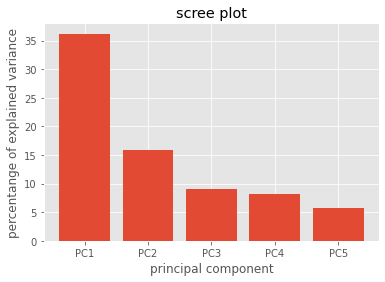

In [38]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('percentange of explained variance')
plt.xlabel('principal component')
plt.title('scree plot')
plt.show()

Next, we'll use a scatterplot to get a visual sense of how our data clusters.  You can see two clusters on the left with an outlier point off to the right.

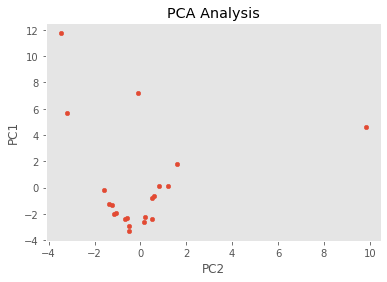

In [39]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X = df_PCA[['PC1','PC2']].values
plt.scatter(X[:,1], X[:,0]+np.random.random(X[:,1].shape)/2,
            s=20)

plt.xlabel('PC2'), plt.ylabel('PC1')
plt.grid()
plt.title('PCA Analysis')
plt.show()

### Cluster Analysis

Next, we'll use an elbow curve to determine the optimal k value

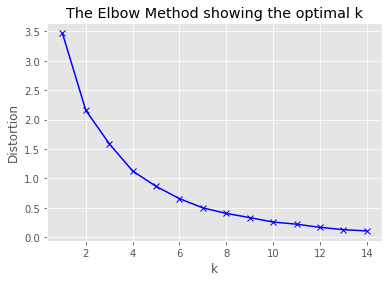

In [40]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

X = df_PCA[['PC1','PC2']].values

# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

To compare, we create a silhouette vs cluster chart to identify the cluster size that has the highest silhouette score.  3 Clusters give us the highest Silhouette score.

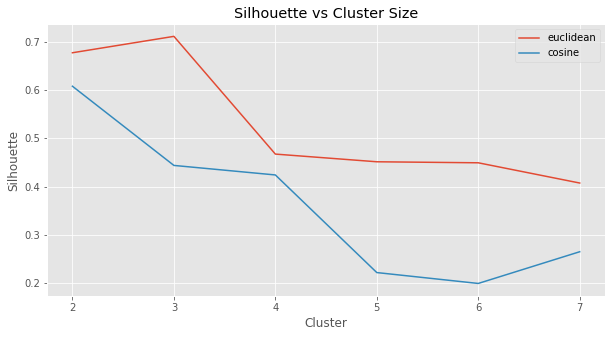

In [41]:
from sklearn.cluster import KMeans
X = df_PCA[['PC1','PC2']].values

seuclid = []
scosine = []
k = range(2,8)
for i in k:
    kmeans_model = KMeans(n_clusters=i, init="k-means++").fit(X)
    labels = kmeans_model.labels_
    seuclid.append(metrics.silhouette_score(X, labels, metric='euclidean'))
    scosine.append(metrics.silhouette_score(X, labels, metric='cosine'))
    
plt.figure(figsize=(10,5))
plt.plot(k,seuclid,label='euclidean')
plt.plot(k,scosine,label='cosine')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show()

Generating a scatter plot again below and applying the cluster labels to the plot, we can see both of the clusters on the left hand side and the single point on the right hand side a different clusters.

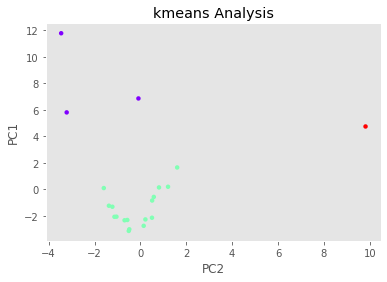

In [42]:
from sklearn.cluster import KMeans


cls = KMeans(n_clusters=3,init='k-means++',random_state=123)
cls.fit(X)

cluster_label = cls.labels_ #the labels from kmeans clustering

%matplotlib inline
plt.scatter(X[:,1], X[:,0]+np.random.random(X[:,1].shape)/2,
            c=cluster_label, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('PC2'), plt.ylabel('PC1')
plt.grid()
plt.title('kmeans Analysis')
plt.show()

## Measuring Effectiveness

The silhouette score is quite high at .71.  Remember that a score closer to 1 signifies dense clusters that are highly separable.

In [43]:
from sklearn.metrics import silhouette_score
silhouette_score(X, cluster_label)

0.710868469909748

###  Describing the Results

Now, we'll take our cluster labels and add them back to the original dataset so that we can begin to analyze the patterns that make up the different clusters.  This will allow us to describe what is different about the clusters.

In [45]:
df_new['cluster_id'] = cluster_label
df_new

,GeoCell,x0_ASSAULT 3 & RELATED OFFENSES,x0_CRIMINAL TRESPASS,x0_DANGEROUS DRUGS,x0_DANGEROUS WEAPONS,x0_FELONY ASSAULT,x0_FRAUDS,x0_GRAND LARCENY,x0_HARRASSMENT 2,x0_MISCELLANEOUS PENAL LAW,...,x3_Spring,x3_Summer,x3_Winter,x4_Day,x4_Early Morning,x4_Evening,x4_Late Night,x4_Morning,x4_Night,cluster_id
0,23.0,2,0,0,0,0,0,0,0,0,...,0,2,0,0,0,1,1,0,0,1
1,25.0,0,0,1,0,0,1,0,0,0,...,0,2,0,0,0,0,2,0,0,1
2,26.0,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,1,1
3,32.0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
4,37.0,1,0,10,1,0,0,1,0,0,...,1,5,1,1,0,2,2,1,7,0
5,45.0,0,0,2,2,2,0,0,0,0,...,1,3,2,2,0,1,2,1,4,0
6,46.0,0,0,1,0,1,2,0,1,0,...,0,3,0,0,0,0,1,0,6,1
7,47.0,1,0,0,0,1,1,1,0,0,...,0,4,0,0,0,2,2,0,1,1
8,48.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
9,55.0,1,0,0,0,0,0,2,1,0,...,1,2,0,0,0,1,1,0,2,1


In [56]:
df_sum = df_new.groupby('cluster_id')['x0_ASSAULT 3 & RELATED OFFENSES',
                                         'x0_CRIMINAL TRESPASS',
                                         'x0_DANGEROUS DRUGS',
                                         'x0_DANGEROUS WEAPONS',
                                         'x0_FELONY ASSAULT',
                                         'x0_FRAUDS',
                                         'x0_GRAND LARCENY',
                                         'x0_HARRASSMENT 2',
                                         'x0_MISCELLANEOUS PENAL LAW',
                                         'x0_OFFENSES AGAINST PUBLIC ADMINI',
                                         'x0_PETIT LARCENY',
                                         'x0_POSSESSION OF STOLEN PROPERTY',
                                         'x0_ROBBERY',
                                         'x1_Friday',
                                         'x1_Monday',
                                         'x1_Saturday',
                                         'x1_Sunday',
                                         'x1_Thursday',
                                         'x1_Tuesday',
                                         'x1_Wednesday',
                                         'x2_August',
                                         'x2_December',
                                         'x2_February',
                                         'x2_July',
                                         'x2_June',
                                         'x2_March',
                                         'x2_May',
                                         'x2_November',
                                         'x2_October',
                                         'x2_September',
                                         'x3_Fall',
                                         'x3_Spring',
                                         'x3_Summer',
                                         'x3_Winter',
                                         'x4_Day',
                                         'x4_Early Morning',
                                         'x4_Evening',
                                         'x4_Late Night',
                                         'x4_Morning',
                                         'x4_Night'].apply(lambda x : x.astype(int).sum())
pd.set_option('display.max_columns', None)
df_sum

C:\Users\BGaither\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,x0_ASSAULT 3 & RELATED OFFENSES,x0_CRIMINAL TRESPASS,x0_DANGEROUS DRUGS,x0_DANGEROUS WEAPONS,x0_FELONY ASSAULT,x0_FRAUDS,x0_GRAND LARCENY,x0_HARRASSMENT 2,x0_MISCELLANEOUS PENAL LAW,x0_OFFENSES AGAINST PUBLIC ADMINI,x0_PETIT LARCENY,x0_POSSESSION OF STOLEN PROPERTY,x0_ROBBERY,x1_Friday,x1_Monday,x1_Saturday,x1_Sunday,x1_Thursday,x1_Tuesday,x1_Wednesday,x2_August,x2_December,x2_February,x2_July,x2_June,x2_March,x2_May,x2_November,x2_October,x2_September,x3_Fall,x3_Spring,x3_Summer,x3_Winter,x4_Day,x4_Early Morning,x4_Evening,x4_Late Night,x4_Morning,x4_Night
cluster_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2,1,18,5,2,0,1,1,1,4,3,0,1,8,7,5,4,5,5,5,3,5,2,8,1,1,4,3,6,6,15,5,12,7,6,0,5,6,3,19
1,7,0,8,2,3,5,3,6,2,3,3,1,3,8,7,4,4,11,9,3,10,1,1,13,2,2,3,4,2,8,14,5,25,2,3,0,8,15,2,18
2,0,2,2,2,0,1,1,0,3,0,0,0,0,2,0,1,3,0,2,3,6,0,0,2,2,0,0,0,0,1,1,0,10,0,0,2,1,3,1,4


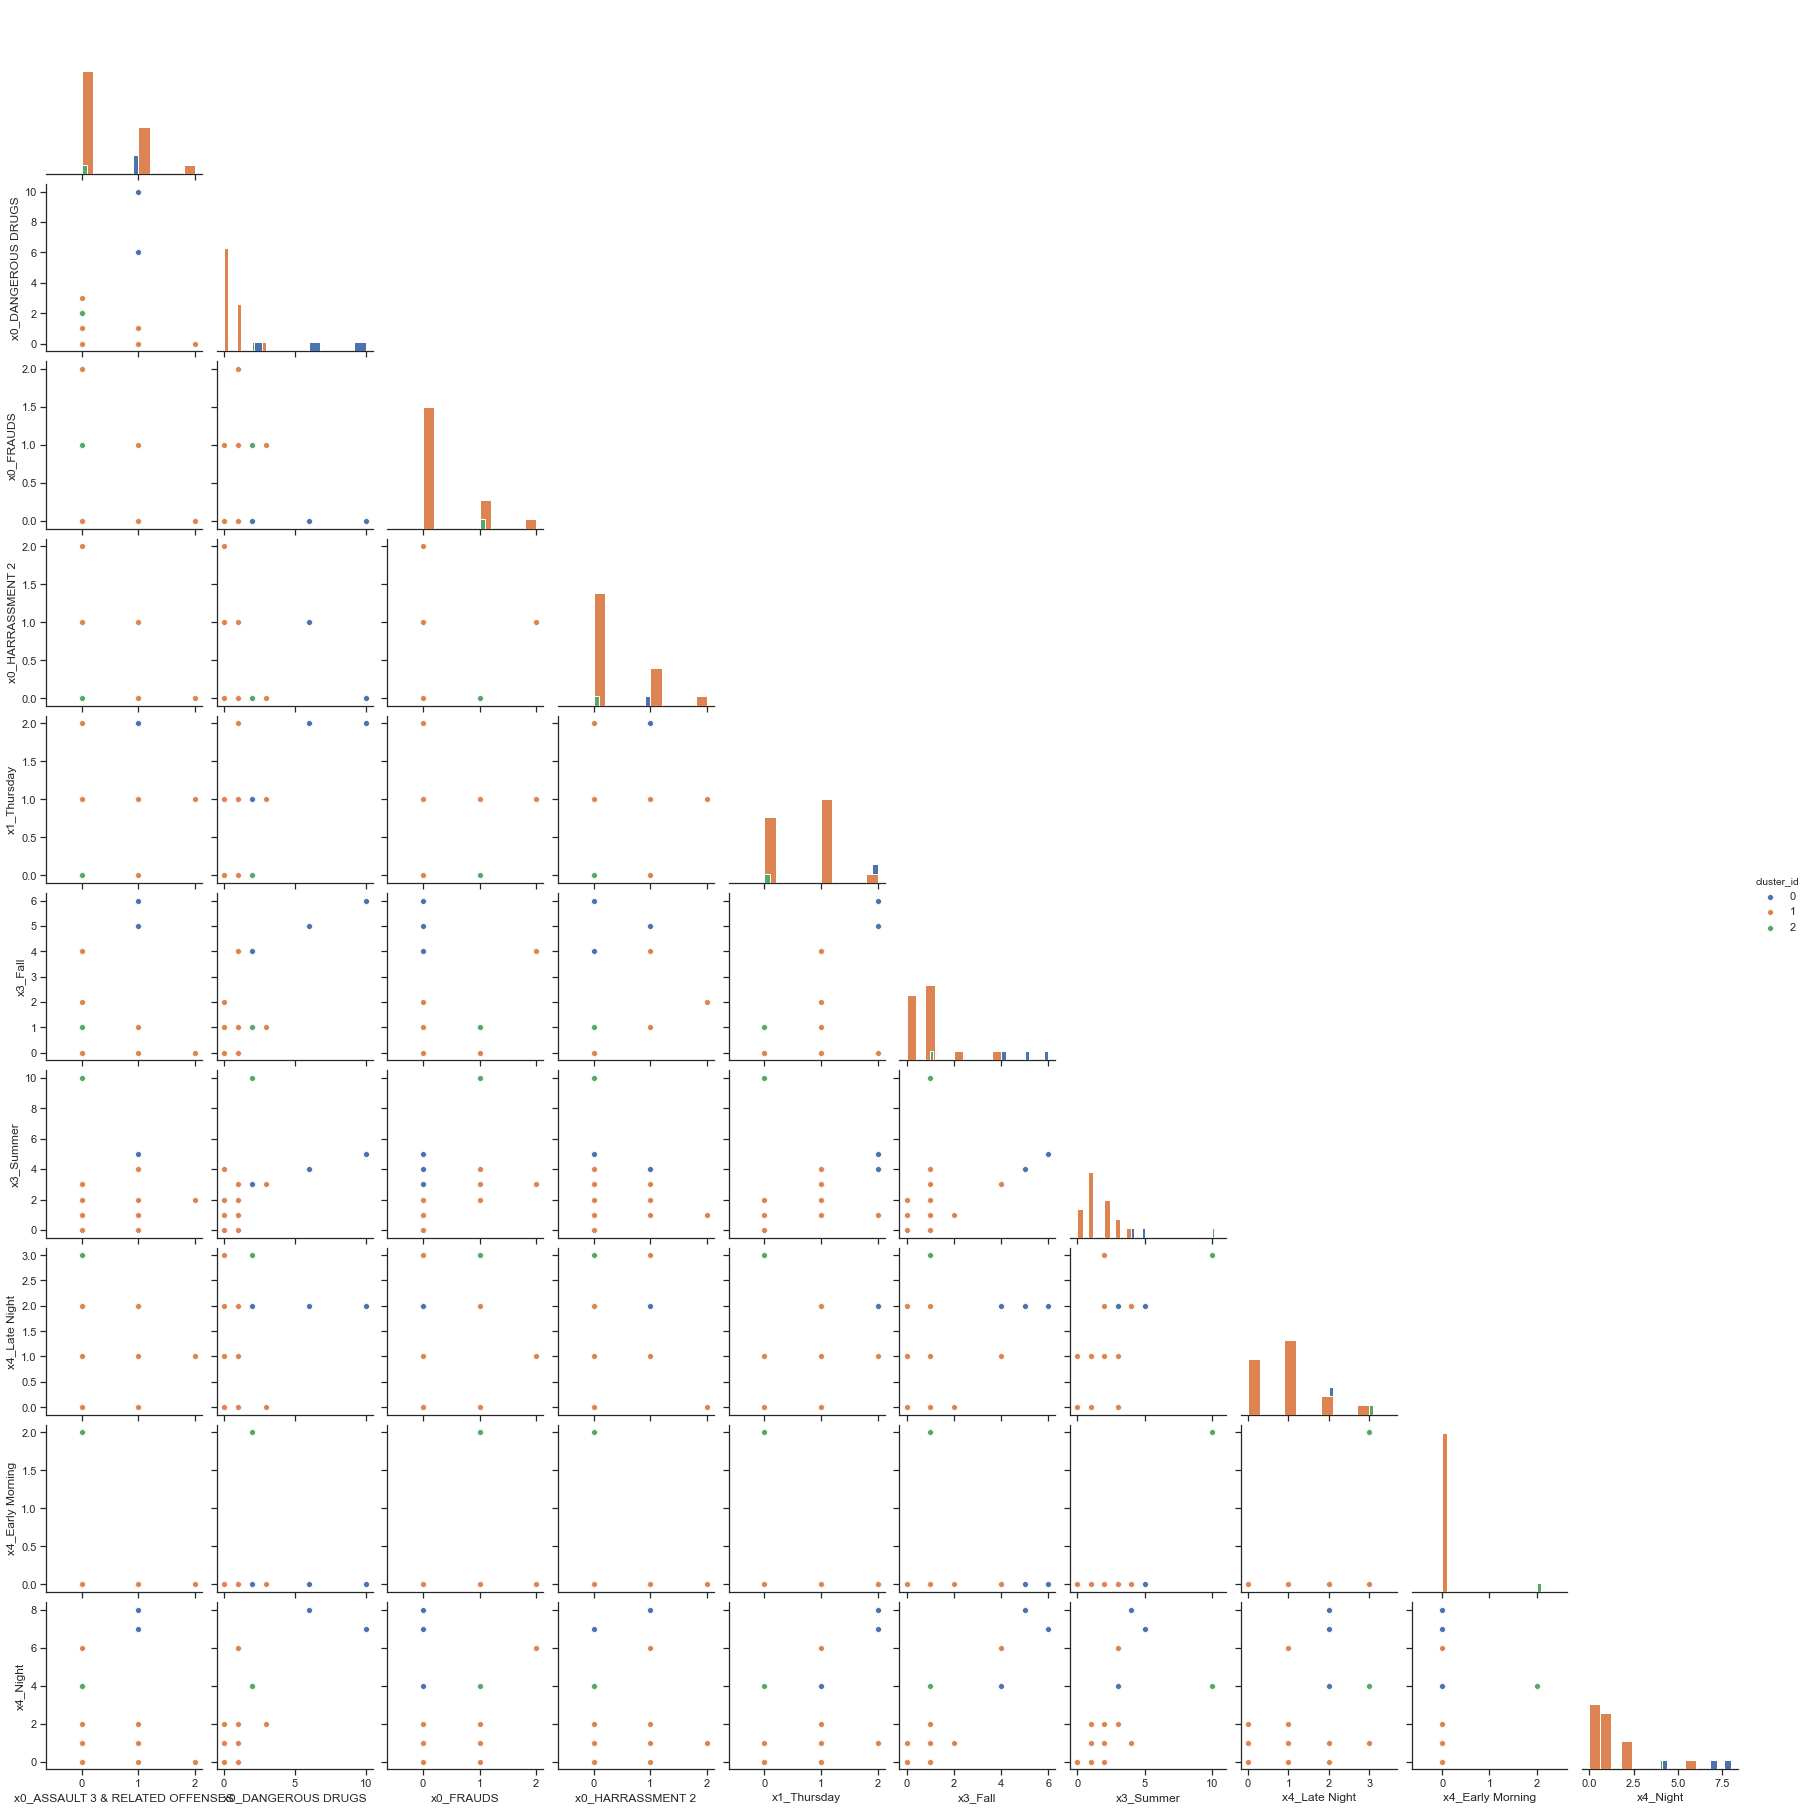

In [67]:
g=sns.pairplot(df_new[['x0_ASSAULT 3 & RELATED OFFENSES','x0_DANGEROUS DRUGS','x0_FRAUDS','x0_HARRASSMENT 2','x1_Thursday','x3_Fall','x3_Summer','x4_Late Night','x4_Early Morning','x4_Night','cluster_id']],hue='cluster_id',diag_kind="hist",corner=True)
g.fig.set_size_inches(25,25)

## Summary

Below, we have used the data analyzed above to give meaning to the clusters identified.  This was done by looking at the mode of categorical data and the average of our continuous data by cluster along with visual representations from the pair plots above.

All clusters appear to primarily occur in the evening/night.

|Cluster id |Cluster Name | Description|
|:--------|:--------|:------------|
|Cluster 0| Violent Warm Weather Weekends | Crimes often include dangerous drugs and weapons.  Crimes occur at night on Friday and Saturday during the Fall and Summer|
|Cluster 1 |Violent Warm Weather Mid-Week | Crimes often include dangerous drugs, weapons and harrassment but also Fraud.  Crimes occur in the middle of the week late in the night during Fall and Summer |
|Cluster 2 |Non-violent Warm Weather Weekends | Crimes often include miscellaneos penal law and trespassing.  Crimes occur on Friday and Sunday at night during the Summer |
